<a href="https://colab.research.google.com/github/Hamza-Ali0237/PyTorch-UNet-Implementation/blob/main/UNet-Image-Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementing UNet Architecture From Scratch Using PyTorch

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T
import torchvision as TV
import matplotlib.pyplot as plt
import os
from PIL import Image

# UNet Model Architecture:

In [15]:
# Define custom UNet model
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Encoder Block
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Transposed Convolutions Block
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)

        # Decoder Block
        self.dec1 = self.conv_block(512, 256)
        self.dec2 = self.conv_block(256, 128)
        self.dec3 = self.conv_block(128, 64)

        self.out = nn.Conv2d(64, out_channels, kernel_size=1)


    # Define Convolutions block for reusability
    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    # Forward Method
    def forward(self, x):

        x1 = self.enc1(x)
        x2 = self.enc2(self.pool(x1))
        x3 = self.enc3(self.pool(x2))
        x4 = self.enc4(self.pool(x3))

        x = self.upconv3(x4)
        x = t.cat([x, x3], dim=1)
        x = self.dec1(x)

        x = self.upconv2(x)
        x = t.cat([x, x2], dim=1)
        x = self.dec2(x)

        x = self.upconv1(x)
        x = t.cat([x, x1], dim=1)
        x = self.dec3(x)

        return self.out(x)


# Custom Dataset Class:

In [11]:
class LungSegmentationDataset(t.utils.data.Dataset):
    def __init__(self, image_paths, mask_paths, image_transform=None, mask_transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.image_filenames = sorted(os.listdir(image_paths))
        self.mask_filenames = sorted(os.listdir(mask_paths))
        self.image_transform = image_transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_dir = os.path.join(self.image_paths, self.image_filenames[idx])
        mask_dir = os.path.join(self.mask_paths, self.mask_filenames[idx])

        image = Image.open(image_dir).convert('RGB')
        mask = Image.open(mask_dir).convert('L')

        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        mask = mask.squeeze(0)
        mask = t.where(mask > 0, 1, 0).float()

        return image, mask

# Image & Mask Transoformations

In [12]:
image_transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

mask_transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor()
])

# Load Data

In [25]:
images_path = "/content/drive/MyDrive/Chest X-Ray Dataset/images"
masks_path = "/content/drive/MyDrive/Chest X-Ray Dataset/masks"


dataset = LungSegmentationDataset(images_path, masks_path, image_transform=image_transform, mask_transform=mask_transform)

# Split data into training and validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = t.utils.data.random_split(dataset, [train_size, val_size])

dataloader_train = t.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)
dataloader_val = t.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False)

# Train Model

In [29]:
device = t.device("cuda" if t.cuda.is_available() else "cpu")

In [30]:
model = UNet(3, 1)
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = t.optim.Adam(model.parameters(), lr=0.001)

Epoch 1/10, Training Loss: 0.42786946669220927
Epoch 1/10, Validation Loss: 0.4044967755675316
Epoch 2/10, Training Loss: 0.3326569514349103
Epoch 2/10, Validation Loss: 0.47946783155202866
Epoch 3/10, Training Loss: 0.3185561913996935
Epoch 3/10, Validation Loss: 0.34072770550847054
Epoch 4/10, Training Loss: 0.30082865823060273
Epoch 4/10, Validation Loss: 0.3583574168384075
Epoch 5/10, Training Loss: 0.2971328657120466
Epoch 5/10, Validation Loss: 0.31854666098952295
Epoch 6/10, Training Loss: 0.29430928248912097
Epoch 6/10, Validation Loss: 0.33572188168764117
Epoch 7/10, Training Loss: 0.2856449745595455
Epoch 7/10, Validation Loss: 0.33725655153393747
Epoch 8/10, Training Loss: 0.2837994765490294
Epoch 8/10, Validation Loss: 0.33624179661273956
Epoch 9/10, Training Loss: 0.2790627064183354
Epoch 9/10, Validation Loss: 0.3248771712183952
Epoch 10/10, Training Loss: 0.2767224103212357
Epoch 10/10, Validation Loss: 0.3124619722366333


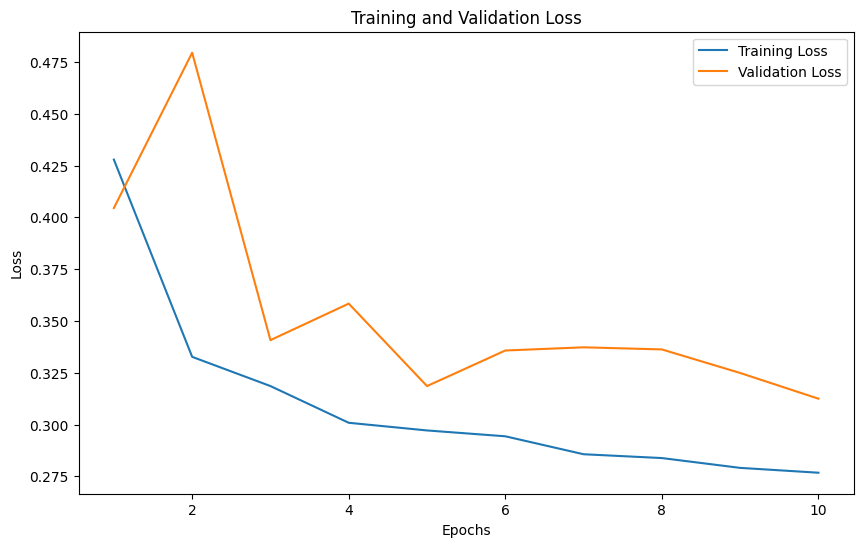

In [31]:
# Initialize lists to store losses
train_losses = []
val_losses = []

# Training and Validation Loop
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0

    for images, masks in dataloader_train:
        images = images.to(device)
        masks = masks.to(device).unsqueeze(1)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(dataloader_train)
    train_losses.append(train_loss)
    print(f"Epoch {epoch}/{num_epochs}, Training Loss: {train_loss}")

    # Validation Loop
    model.eval()
    val_loss = 0.0
    with t.no_grad():
        for images, masks in dataloader_val:
            images = images.to(device)
            masks = masks.to(device).unsqueeze(1)

            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

    val_loss = val_loss / len(dataloader_val)
    val_losses.append(val_loss)
    print(f"Epoch {epoch}/{num_epochs}, Validation Loss: {val_loss}")

# Plot Training and Validation Losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# Test Model

In [36]:
def test_and_visualize(model, dataset, num_samples=5):
    device = next(model.parameters()).device
    model.eval()
    indices = t.randint(0, len(dataset), (num_samples,))
    plt.figure(figsize=(15, 10))

    for i, idx in enumerate(indices):
        image, true_mask = dataset[idx]
        image = image.unsqueeze(0).to(device)

        with t.no_grad():
            pred_mask = model(image)
            pred_mask = t.sigmoid(pred_mask).squeeze().cpu().numpy()

        pred_mask = (pred_mask > 0.5).astype(float)

        plt.subplot(num_samples, 4, i * 4 + 1)
        plt.imshow(image.squeeze(0).permute(1, 2, 0).cpu().numpy())
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(num_samples, 4, i * 4 + 2)
        plt.imshow(true_mask.squeeze(0).numpy(), cmap="gray")
        plt.title("True Mask")
        plt.axis("off")

        plt.subplot(num_samples, 4, i * 4 + 3)
        plt.imshow(pred_mask, cmap="gray")
        plt.title("Predicted Mask")
        plt.axis("off")

        # Overlay predicted mask on image
        plt.subplot(num_samples, 4, i * 4 + 4)
        plt.imshow(image.squeeze(0).permute(1, 2, 0).cpu().numpy())
        plt.imshow(pred_mask, cmap="jet", alpha=0.5)
        plt.title("Overlay")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

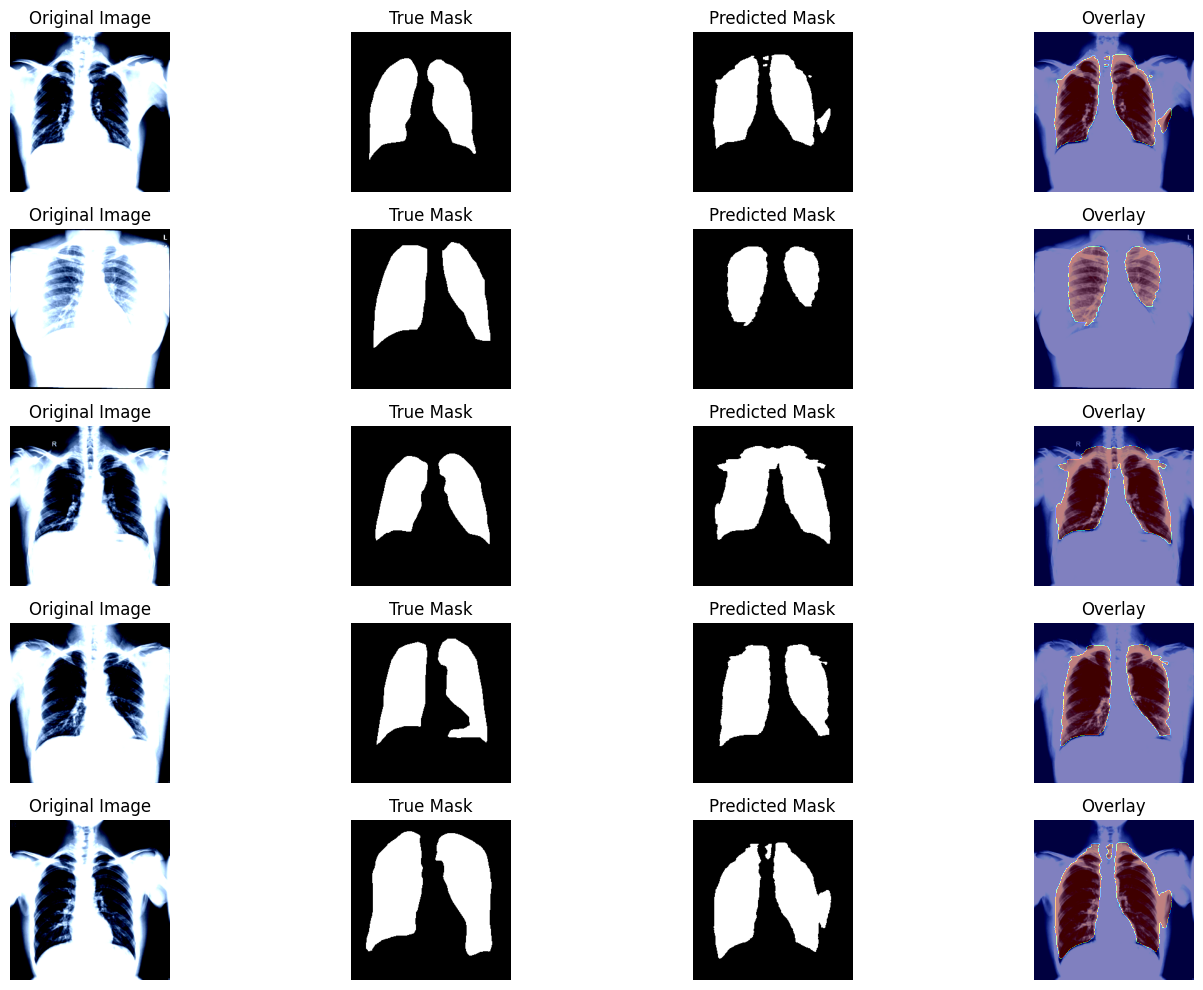

In [37]:
test_and_visualize(model, val_dataset)